# Image Generation with Convolutional Variational AutoEncoder

## Imports

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import time
from datetime import timedelta
import PIL
import imageio

from IPython import display

TensorFlow 2.x selected.


## Load the Dataset

We have used the MNIST Handwritten digits dataset.

In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


## Preprocessing

In this pahse we have only rehaped the input data and introduced simple transforms to convert from a 256 scale gery scale image to just 2 scaled one (i.e. black or white), simply so the model only focuses on that. 

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

## Use *tf.data* to create batches and shuffle the dataset

In [0]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

## Models

Here is the class that holds the models and also provides some of the important functionalities associated to VAEs.

In [0]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
        tf.keras.layers.Conv2D(64, (5, 5), (2, 2), input_shape=(28, 28, 1), padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, (5, 5), (2, 2), padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(self.latent_dim + self.latent_dim),
      ], name='Inference_Net'
    )

    self.generative_net = tf.keras.Sequential(
      [
        tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(self.latent_dim,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape((7, 7, 256)),
        tf.keras.layers.Conv2DTranspose(128, (5, 5), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(64, (5, 5), (2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(1, (5, 5), (2, 2), padding='same', use_bias=False, activation=tf.nn.tanh),
      ], name='Generative_Net'
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True, training=False)

  def encode(self, x, training=True):
    mean, logvar = tf.split(self.inference_net(x, training=training), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False, training=True):
    logits = self.generative_net(z,training=training)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits
    
  def save(self, fname=None):
    if fname:
      self.inference_net.save_weights(f'{fname}-inference-net-weights.h5')
      self.generative_net.save_weights(f'{fname}-generative-net-weights.h5')
    else:
      self.inference_net.save_weights('cvae-inference-net-weights.h5')
      self.generative_net.save_weights('cvae-generative-net-weights.h5')
  
  def load(self, fname=None):
    if fname:
      self.inference_net.load_weights(f'{fname}-inference-net-weights.h5')
      self.generative_net.load_weights(f'{fname}-generative-net-weights.h5')
    else:
      self.inference_net.load_weights('cvae-inference-net-weights.h5')
      self.generative_net.load_weights('cvae-generative-net-weights.h5')

## Loss Function and Optimizer

In [0]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

## Parameters for training and the CVAE Object

### Parameters:

- *epochs*: Number of epochs for training
- *latent_dim*: Dimentionality of the Latent Space
- *num_examples_to_generate*: Number of samples to be generated during the training and testing process
- *random_vector_for_generation*: Random Vector for Image Generation during Training
- *model*: CVAE Model object.

In [0]:
epochs = 500
latent_dim = 100
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

### Model Summaries

In [9]:
# Inference Net Summary
model.inference_net.summary()

Model: "Inference_Net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)            

In [10]:
# Generative Net
model.generative_net.summary()

Model: "Generative_Net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)      

### Function to Generate and Save Images

In [0]:
def generate_and_save_images(model, epoch, test_input, folder='images', save_img=False):
  if not os.path.exists(folder): os.mkdir(folder)
  
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
      plt.axis('off')

  if save_img: plt.savefig(f'./{folder}/{folder}_{epoch:04d}.png')
  
  plt.show()

## Training Block

In [0]:
def train(train_dataset, test_dataset, epochs):
  generate_and_save_images(model, 0, random_vector_for_generation, save_img=True)

  train_losses = []
  test_losses = []
  time_elapsed = 0
  start_training = time.perf_counter()

  for epoch in range(1, epochs + 1):
    train_loss = tf.keras.metrics.Mean()
    test_loss = tf.keras.metrics.Mean()
    
    start_time = time.perf_counter()
    for train_x in train_dataset:
      train_loss(compute_apply_gradients(model, train_x, optimizer))

    for test_x in test_dataset:
      test_loss(compute_loss(model, test_x))
    elapsed = time.perf_counter() - start_time

    train_losses.append(-train_loss.result())
    test_losses.append(-test_loss.result())

    display.clear_output(wait=True)
    print(f'ETA: {timedelta(seconds=int(elapsed * (epochs - epoch)))}\tEpoch: {epoch}/{epochs}\tTrain set ELBO: {train_losses[-1]:.4f}\tTest set ELBO: {train_losses[-1]:.4f}')
    generate_and_save_images(model, epoch, random_vector_for_generation, save_img=(epoch % 5 == 0))

  training_time = time.perf_counter() - start_training
  
  return train_losses, test_losses, training_time

ETA: 0:00:00	Epoch: 500/500	Train set ELBO: -290.8408	Test set ELBO: -290.8408


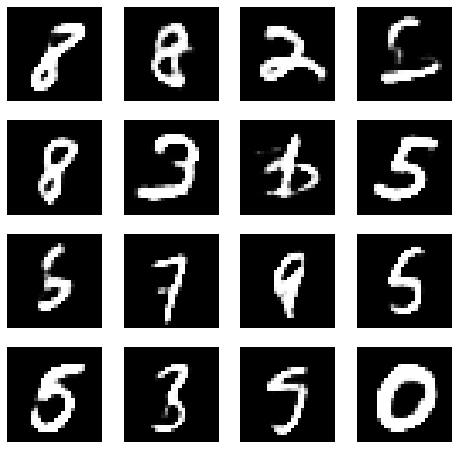

In [13]:
train_losses, test_losses, training_time = train(train_dataset, test_dataset, epochs)

In [14]:
print(f'Training Time: {timedelta(seconds=int(training_time))}')

Training Time: 1:50:53


## Losses

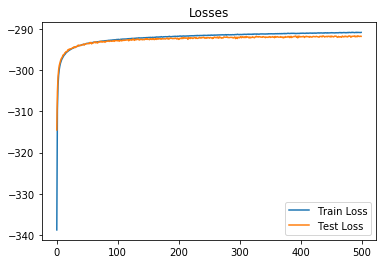

In [15]:
plt.plot(list(range(epochs)), train_losses, label='Train Loss')
plt.plot(list(range(epochs)), test_losses, label='Test Loss')
plt.title('Losses')
plt.legend()

plt.savefig('cvae-losses.png')
plt.show()

## Samples And Benchmark Predictions

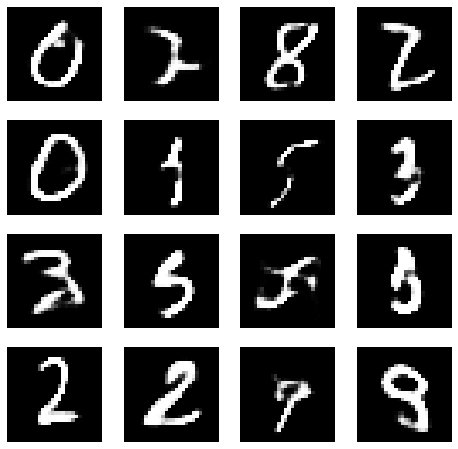

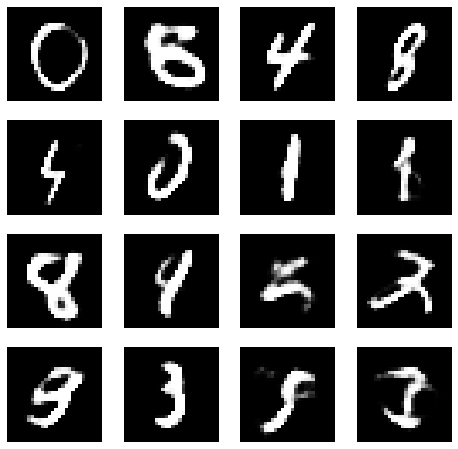

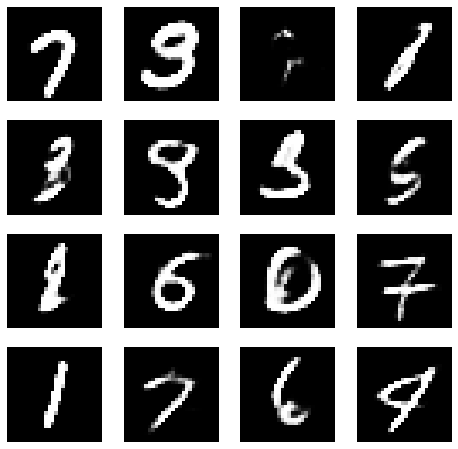

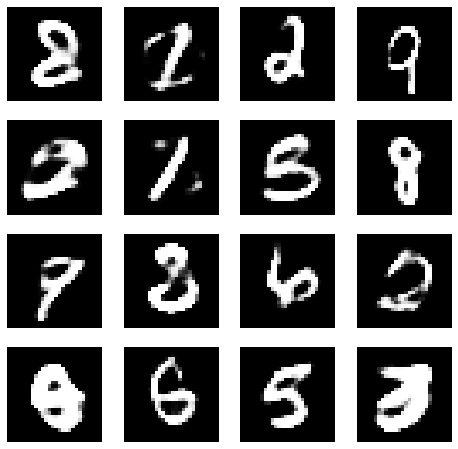

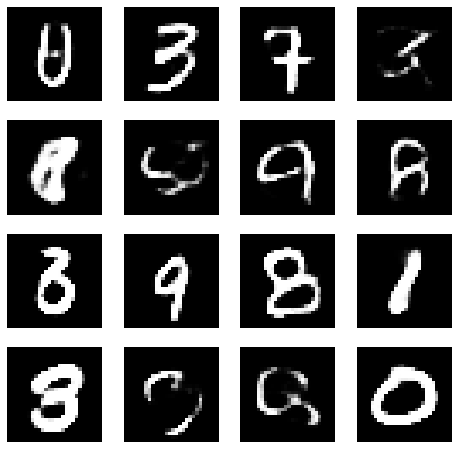

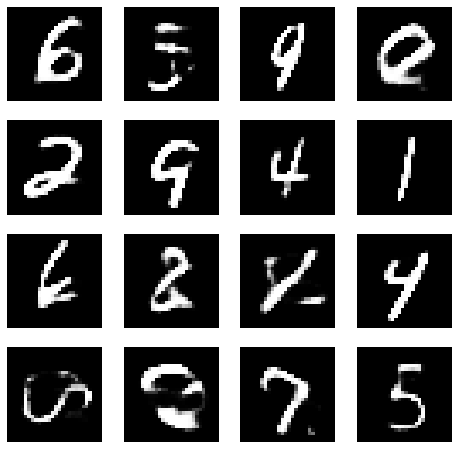

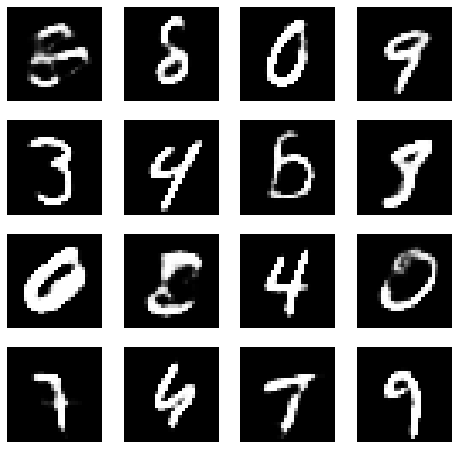

In [18]:
num_seed_sets = 7
seeds = tf.random.normal(shape=[num_seed_sets, num_examples_to_generate, latent_dim])
for i in range(num_seed_sets):
  generate_and_save_images(model, i, seeds[i], 'samples', True)
seeds = seeds.numpy().reshape(-1, latent_dim)

In [19]:
samples = model.sample(seeds)

benchmark_model = tf.keras.models.load_model('mnist-benchmark.h5')
predictions = benchmark_model.predict_classes(samples)

print('Predictions for above generated imagrs:\n')
print(predictions.reshape(num_seed_sets, 4, 4))

Predictions for above generated imagrs:

[[[0 2 8 8]
  [0 8 5 3]
  [3 5 8 5]
  [2 8 8 8]]

 [[0 8 4 8]
  [4 2 1 8]
  [8 8 8 8]
  [9 3 8 3]]

 [[7 3 8 8]
  [8 8 3 8]
  [8 5 0 7]
  [8 8 8 4]]

 [[8 8 2 9]
  [2 8 5 8]
  [8 8 6 2]
  [8 8 5 3]]

 [[0 3 7 8]
  [8 8 9 8]
  [8 9 8 8]
  [3 5 9 0]]

 [[8 8 9 8]
  [2 9 4 8]
  [8 8 8 4]
  [8 8 7 5]]

 [[8 8 0 9]
  [3 4 5 8]
  [0 5 4 0]
  [8 4 7 9]]]


## Benchmark Model Summary

In [20]:
benchmark_model.summary()

Model: "MNIST_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 8)           6408      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               